In [1]:
import numpy as np
import pandas as pd
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.analysis import parcoords
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
from collections import defaultdict

from ema_workbench import (
    Model,
    MultiprocessingEvaluator,
    ScalarOutcome,
    IntegerParameter,
    optimize,
    Scenario,
    Policy
)

In [2]:
results = pd.read_csv("./output/20230614T1059_results_seed_ds.csv")

In [3]:
results = results.loc[[0, 1, 2, 3]]

In [4]:
model, steps = get_model_for_problem_formulation(7)

In [5]:
policies = results
policies = policies.drop([o.name for o in model.outcomes], axis=1)
policies

,Unnamed: 0,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,0,1,0,1,0,0,0,1,0,1,...,2,5,5,5,1,2,2,10,6,0
1,1,0,0,1,0,0,0,0,1,1,...,3,6,0,6,3,5,6,2,5,3
2,2,0,0,1,0,0,0,1,1,1,...,2,5,5,4,9,2,2,10,3,0
3,3,0,0,0,1,0,0,0,0,1,...,0,7,1,7,9,1,5,2,7,1


In [6]:
policies_to_evaluate = []

for _, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(_), **policy.to_dict()))

In [7]:
n_scenarios = 50
with MultiprocessingEvaluator(model) as evaluator:
    results2 = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

100%|████████████████████████████████████████| 200/200 [01:02<00:00,  3.21it/s]


## Calculating score based on signal-to-noise ratio

In [8]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)

    if direction==ScalarOutcome.MINIMIZE:
        return mean*std
    else:
        return mean/std

In [9]:
experiments, outcomes = results2

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A.4 Expected Annual Damage,A.4 Expected Number of Deaths,Total Infrastructure Costs,Total Expected Annual Damage,Total Expected Number of Deaths
0,3.096568e+14,1.198162e-06,0.000000,1.232886e+16,0.000081
1,1.090991e+13,5.480333e-08,93.337355,1.481303e+16,0.000100
2,9.686464e+08,1.179528e-11,98.431564,3.396993e+16,0.000274
3,1.081416e+09,1.383884e-11,0.000000,1.508340e+17,0.001571


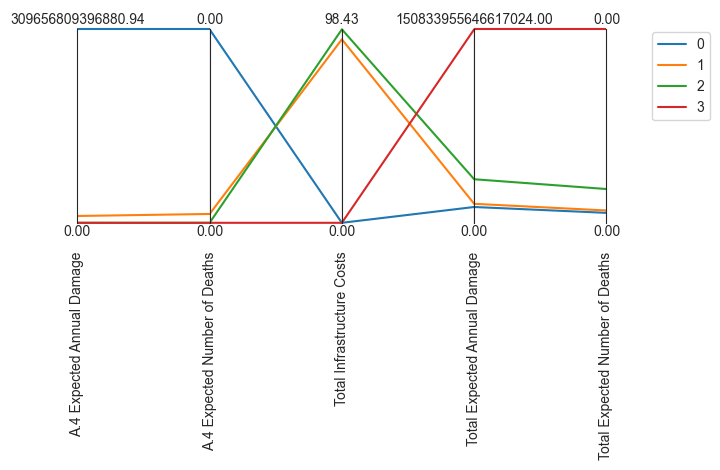

In [10]:
data = scores
limits = parcoords.get_limits(data)
limits.loc[0, ['A.4 Expected Annual Damage', 'A.4 Expected Number of Deaths', 'Total Infrastructure Costs',
               'Total Expected Annual Damage', 'Total Expected Number of Deaths']] = 0

colors = sns.color_palette()
paraxes = parcoords.ParallelAxes(limits, fontsize=10)

for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()

plt.show()

## Calculating robustness using maximum regret

### Definitions

Regret: the difference between policy performance in a specific scenario versus the performance of the best possible result in that scenario (or versus a reference policy).

Maximum regret: max(regret) across all scenarios

Defined for each policy under each scenario

Objective: minimize regret


In [11]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [12]:
overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

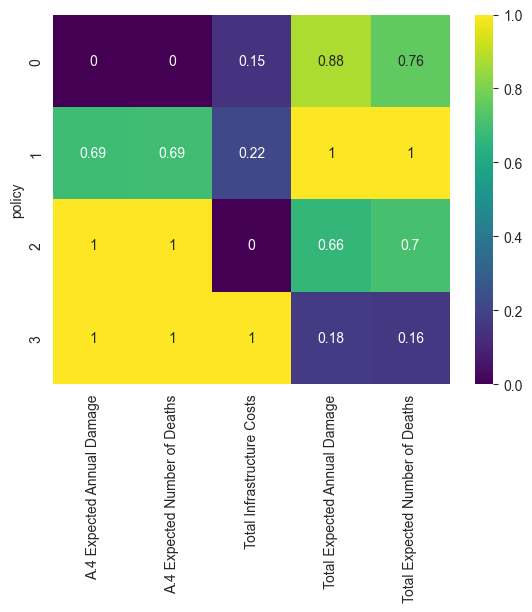

In [13]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

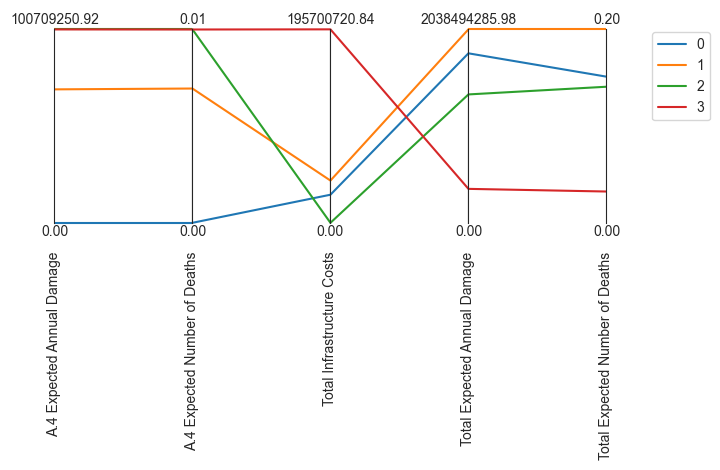

In [14]:
colors = sns.color_palette()

data = max_regret

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, ['A.4 Expected Annual Damage', 'A.4 Expected Number of Deaths', 'Total Infrastructure Costs',
               'Total Expected Annual Damage', 'Total Expected Number of Deaths']] = 0

paraxes = parcoords.ParallelAxes(limits, fontsize=10)

for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
    
plt.show()

## Calculating robustness using regret distribution

In [15]:
policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

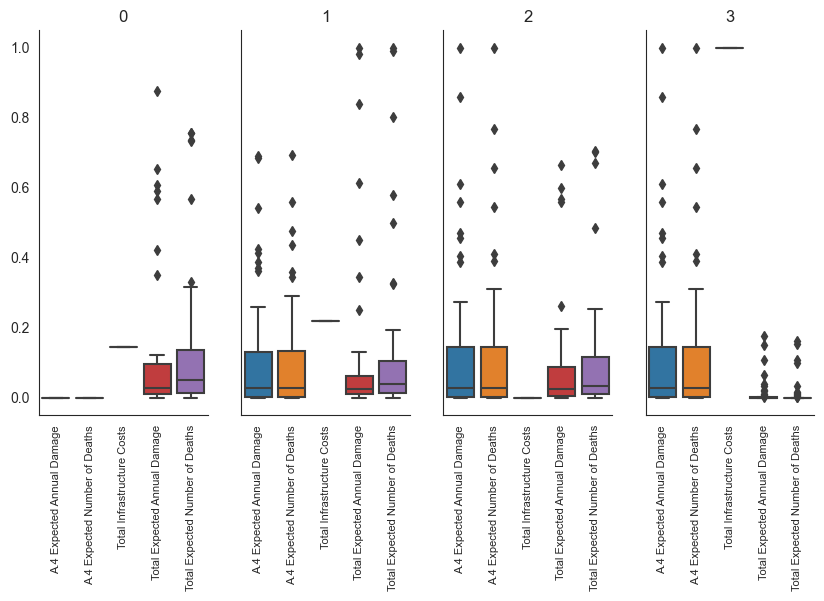

In [20]:
# this generates a 2 plots with a shared y and x axis
fig, axes = plt.subplots(ncols=4, figsize=(10,5), 
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this. 


# zip allows us to zip together the list of axes and the list of 
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    b = sns.boxplot(data=data, ax=ax)
    b.tick_params(labelsize=8, axis = 'x', rotation=90)
    
    # removes top and left hand black outline of axes
    sns.despine()
    
    # ensure we know which policy the figure is for
    ax.set_title(str(policy))
plt.show()

## Post-robustness scenario discovery